# Imports

In [ ]:
from abc import ABC, abstractproperty, abstractmethod
from typing import List, Tuple

import random

import numpy as np

# Hyperparameters

In [ ]:
GOOD_CARD_REWARD = 1
DRAW_CARD_REWARD = -0.2
LOSE_GAME_REWARD = -0.5

HIDDEN_LAYER_SIZE = 80

# UnoGame

Encoding cards:

* 100 total cards for now
* 25 red, 25 green, 25 blue, 25 yellow - each of which gets mapped to a number between 0 and 3
* for every color, there is one 0, and two of 1 through 9, and two skips, +2s, and reverses - each unique value gets mapped to a number between 0 and 13

In [ ]:
def DEBUG(msg, verbose=False):
  if (verbose):
    print(msg)

In [ ]:
def try_move(game, verbose=False):

  agent = game.get_turn_agent()
  move = agent.get_move(save_gradient=True) #debugging

  penalty = game.get_penalty()
  top = game.get_top()

  #draw card logic
  if (move == (-1, -1)):
    DEBUG(f"{agent.get_name()} draws {penalty} cards.", verbose)

    #just one card
    if (penalty <= 1):
      agent.add_card(game.get_card_from_deck())
      game.change_turn()
      return

    #multiple cards
    else:
      for i in range(game.get_penalty()):
        agent.add_card(game.get_card_from_deck())
      game.reset_penalty()
      game.change_turn()
      return


  #try to play a card not in hand logic
  elif (move not in agent.get_hand()):
    DEBUG(f"move: {game.get_movecount()}, {agent.get_name()} does not have {move} in hand {agent.get_hand()}", verbose=True)

    game.set_done(True)
    return


  #illegal move logic
  elif (move[0] != top[0] and move[1] != top[1]):
    DEBUG(f"move: {game.get_movecount()}, {agent.get_name()} played {move} but the top card is {top}", verbose=True)

    game.set_done(True)
    return


  #valid move logic
  elif (move[0] == top[0] or move[1] == top[1]):
    agent.remove_card(move)
    game.add_to_discard(move)

    #reverse
    if (move[1] == 10):
      DEBUG(f"{agent.get_name()} used {move} reverse onto {top}", verbose)
      game.change_dir()
      game.change_turn()
      return

    #skip
    elif (move[1] == 11):
      DEBUG(f"{agent.get_name()} used {move} skip onto {top}", verbose)
      game.change_turn(2)
      return

    #two
    elif (move[1] == 12):
      DEBUG(f"{agent.get_name()} used {move} plustwo onto {top}", verbose)
      game.increase_penalty(2)
      game.change_turn()
      return

    #any other normal card
    else:
      DEBUG(f"{agent.get_name()} played {move} onto {top}", verbose)
      game.change_turn()
      return

In [ ]:
class UnoGameMaster():
  def __init__(self):
    self._deck: List[Tuple[int, int]] = []

    self._discard: List[Tuple[int, int]] = []
    self._top = None

    self._agents = []
    self._index = 0 #index of which agents turn it is
    self._dir = 1 #direction of play
    self._movecount = 1

    self._penalty = 1

    self._done = False


  def print_state(self):
    print(f"deck:\n{self._deck}\nsize: {len(self._deck)}\n")
    print(f"discard:\n{self._discard}\nsize: {len(self._discard)}\n")
    print(f"top:\n{self._top}\n")
    print(f"agents:\n{[agent.get_name() for agent in self._agents]}\n")
    print(f"hands:\n{[agent.get_hand() for agent in self._agents]}\n")
    print(f"movecount:\n{self._movecount}\n")
    print(f"penalty:\n{self._penalty}\n")


  def setup(self, agents) -> bool:
    """
    reset and shuffle the deck, deal cards, and start the discard pile.

    Parameters:
    - List[UnoAgent]: agents in the game

    Returns:
    - True

    """
    self._deck = []
    for color in range(0, 4):
      self._deck.append((color, 0))
      for value in range(1, 13):
        self._deck.append((color, value))
        self._deck.append((color, value))
    random.shuffle(self._deck)

    self._discard = []
    self._top = None

    for agent in agents:
      agent.clear_hand()
    self._agents = agents
    self._index = 0
    self._dir = 1
    self._movecount = 1

    self._penalty = 1

    self._done = False

    #deal cards
    for i in range(7):
      for agent in self._agents:
        agent.add_card(self.get_card_from_deck())

    start_discard = self.get_card_from_deck()
    self.add_to_discard(start_discard) #does not do active card effects
    return True

  def set_done(self, value):
    self._done = value

  def is_done(self) -> bool:
    return self._done

  def change_dir(self):
    #reverse
    self._dir = -(self._dir)

  def change_turn(self, value=1):
    #when someone makes a move, then the next player to go is decided by this
    self._index += (self._dir * value)

  def get_agents(self):
    return self._agents

  def get_movecount(self):
    return self._movecount

  def increase_movecount(self, amount=1):
    self._movecount += amount

  def get_top(self) -> Tuple[int, int]:
    return self._top

  def get_penalty(self) -> int:
    return self._penalty

  def reset_penalty(self):
    self._penalty = 1

  def increase_penalty(self, amount):
    #how much to increase the penalty by
    if (self._penalty <= 1):
      self._penalty = amount
    else:
      self._penalty += amount

  def get_turn_agent(self):
    self._index = self._index % len(self._agents)
    return self._agents[self._index]

  def get_card_from_deck(self) -> Tuple[int, int]:
    """
    pops the top card of the deck and returns it, adding in discard pile if empty.
    shuffles in the discard pile minus top card if empty deck.

    Returns:
    - Tuple[int, int]: card
    """
    if (len(self._deck) < 1):
      self._deck = self._discard[:-1].copy()
      random.shuffle(self._deck)
      self._discard = [self._top]

    if (len(self._deck) == 0):
      self.print_state()

    return self._deck.pop()

  def add_to_discard(self, card: Tuple[int, int]):
    """
    puts card in discard pile and makes it the top card.

    Parameters:
    - Tuple[int, int]: card
    """
    self._discard.append(card)
    self._top = card
    return True

  def add_to_deck(self, card: Tuple[int, int]):
    """
    puts card at the bottom of the deck.

    Parameters:
    - Tuple[int, int]

    Returns:
    - True
    """
    self._deck.insert(0, card)
    return True

In [ ]:
def check_win(game, verbose=False):

  #if (game.is_done()):
    #DEBUG
    #print(f"no winner: illegal move played")


  for agent in game.get_agents():
    if agent.get_hand_count() == 0:
      game.set_done(True)
      DEBUG(f"winner: {agent.get_name()}, total moves: {game.get_movecount()}", verbose)

In [ ]:
def run_simulation(game, agents, max_moves, verbose=False):
  game.setup(agents)
  while ((not game.is_done()) and game.get_movecount() < max_moves):
    try_move(game, verbose)
    check_win(game, verbose=True)

    game.increase_movecount()

  for agent in agents:
    agent.learn()

  return game.get_movecount()



# Agent Interface

In [ ]:
class UnoAgent(ABC):

  @abstractmethod
  def get_move(self) -> Tuple[int, int]:
    """
    which move to make

    Returns:
    - Tuple[int, int]: card to play, or (-1, -1) to draw
    """
    pass


  def get_name(self):
    return self._name


  def get_hand(self) -> List[Tuple[int, int]]:
    """
    Returns:
    - list[tuple[int, int]]: list of current hand cards
    """
    return self._hand


  def get_hand_count(self) -> int:
    """
    Returns:
    - int: number of cards in hand
    """
    return len(self._hand)


  def add_card(self, card: Tuple[int, int]) -> bool:
    """
    adds a card to the hand

    Parameters:
    - Tuple[int, int]: card

    Returns:
    - bool: success
    """
    self._hand.append(card)
    return True


  def remove_card(self, card: Tuple[int, int]) -> bool:
    """
    removes a card from the hand

    Parameters:
    - int: the index of the card in the current hand to remove

    Returns:
    - bool: success
    """

    if (card not in self._hand):
      return False

    self._hand.remove(card)
    return True


  def empty_hand(self) -> bool:
    """
    checks for no cards in hand

    Returns:
    - bool: no cards in hand
    """
    if (len(self._hand) < 1):
      return True
    return False


  def clear_hand(self) -> bool:
    """
    removes all cards from hand

    Returns:
    - True
    """
    self._hand = []
    return True



# Basic Agent

In [ ]:
class BasicAgent(UnoAgent):
  def __init__(self, name: str, game: UnoGameMaster):
    self._hand: List[Tuple[int, int]] = []
    self._name = name
    self._game = game

  def get_move(self, save_gradient=False) -> Tuple[int, int]:
    """
    picks the first playable card

    Returns:
    - Tuple[int, int]: card
    """
    pen = self._game.get_penalty()
    top = self._game.get_top()

    for card in self._hand:
      if ((card[0] == top[0] and pen <= 1) or card[1] == top[1]):
        return card
    return (-1, -1)

  def learn(self):
    pass

# Encoding and Decoding

In [ ]:
def index_to_card(i):
  if (i == 52):
    return (-1, -1)
  color = i // 13
  number = i % 13
  return (color, number)

def card_to_index(c):
  if (c == (-1, -1)):
    return 52
  color, number = c
  return ((color * 13) + number)

#debug
for i in range(53):
  if (card_to_index(index_to_card(i)) != i):
    print("fail")

Encoding the state of the game, given the game and the agent.

* 17 neurons for the top card (4 for color and 13 for number)
* 3 for penalty (number of stacked +2 cards)
* 104 neurons for the hand (1 per card and considering duplicates)

Total: 124 neurons

In [ ]:
def encode_game_state(game):
  """
  encodes the current game state into a column vector

  Parameters:
  - game: the game to encode

  Returns:
  - np.ndarray: column vector
  """
  #top card 17 neurons
  encoded_top_card = np.zeros(17)

  color, number = game.get_top()

  encoded_top_card[color] = 1
  encoded_top_card[(color + 1) + number] = 1

  #penalty (maximum of 3 stacked +2 cards) 3 neurons
  encoded_penalty = np.zeros(3)
  penalty = game.get_penalty()

  if (penalty > 6):
    encoded_penalty[2] = 1
  elif (penalty > 1):
    encoded_penalty[int((penalty / 2) - 1)] = 1

  #put these vectors together
  out = np.concatenate((encoded_top_card, encoded_penalty), axis=0)
  out = out.reshape(-1, 1)

  return out

In [ ]:
def encode_agent_hand(agent) -> np.ndarray:
  """
  encodes the agent's hand into a column vector

  Parameters:
  - agent: whose hand to encode

  Returns:
  - np.ndarray: column vector
  """
  #hand
  encoded_hand = np.zeros((52, 2))

  for card in agent.get_hand():
    i = card_to_index(card)

    if (encoded_hand[i, 0] == 0):
      encoded_hand[i, 0] = 1
    else:
      encoded_hand[i, 1] = 1

  encoded_hand = encoded_hand.flatten()

  out = encoded_hand.reshape(-1, 1)

  return out


In [ ]:
def encode_state(agent, game):
  return np.vstack((encode_agent_hand(agent), encode_game_state(game)))

Decode the output of a decision.

* 52 neurons for the card to play (1 for each card color/value combo)
* 1 neuron if drawing a card

Total: 53 neurons

In [ ]:
def stochastic_decision(probability_distribution):
  action_index = np.random.choice(len(probability_distribution), p=probability_distribution.flatten())
  return action_index

In [ ]:
def decode_decision(probability_distribution, action_index=None, deterministic=False):
  if (deterministic):
    action_index = np.argmax(probability_distribution)
  elif (action_index is not None):
    action_index
  else:
    action_index = stochastic_decision(probability_distribution)

  if (action_index == len(probability_distribution) - 1):
    return (-1, -1)
  else:
    return index_to_card(action_index)

Helper functions for changing the weights of neural net

In [ ]:
def ReLU(Z):
  #x if x > 0
  A = np.maximum(Z, 0)
  return A

def ReLU_deriv(Z):
  return Z > 0

def leaky_ReLU(Z, alpha=0.01):
  A = np.maximum(Z, Z * alpha)
  return A

def leaky_ReLU_deriv(Z, alpha=0.01):
  return np.where(Z > 0, 1, alpha)

def sigmoid(Z):
  A = (1 / (1 + np.exp(-Z)))
  return A

def sigmoid_deriv(Z):
  A = sigmoid(Z)
  return (A * (1 - A))

def softmax(Z):
  exp_Z = np.exp(Z - np.max(Z))
  A = exp_Z / np.sum(exp_Z)
  return A

def softmax_deriv(Z):
  S = softmax(Z)
  return S * (1 - S)

def div(Z):
  A = Z / np.max(Z)
  return A

def div_deriv(Z):
  return (1 / np.max(Z))

# Reward Function


Trajectory and rewards


In [ ]:
def move_reward(game, agent, move):
  penalty = game.get_penalty()
  top = game.get_top()

  #draw
  if (move == (-1, -1)):
    return max(-1, penalty * DRAW_CARD_REWARD)

  if ((move in agent.get_hand()) and (move[0] == top[0] or move[1] == top[1])):
    return GOOD_CARD_REWARD
  else:
    return LOSE_GAME_REWARD

  # cum_reward = LOSE_GAME_REWARD
  # if (move in agent.get_hand()):
  #   cum_reward += GOOD_CARD_REWARD
  # if (move[0] == top[0] or move[1] == top[1]):
  #   cum_reward += GOOD_CARD_REWARD
  # return cum_reward

  # #illegal move
  # elif ((move not in agent.get_hand()) or (move[0] != top[0] and move[1] != top[1])):
  #   return LOSE_GAME_REWARD

  # #valid card is played
  # else:
  #   return GOOD_CARD_REWARD

In [ ]:
def reward_vector(game, agent):
  output = np.zeros((53, 1))

  for i in range(53):
    move = index_to_card(i)
    output[i] = move_reward(game, agent, move)

  return output

In [ ]:
def advantages(game, agent):
  predicted_rewards = reward_vector(game, agent)
  received_reward = move_reward(game, agent, agent.get_move())
  return predicted_rewards - received_reward

# RLAgent

In [ ]:
class RLAgent(UnoAgent):
  def __init__(self, name, game, learn_rate):
    self._hand: List[Tuple[int, int]] = []
    self._name = name
    self._game = game

    #weight matrices
    self._w1 = np.zeros((HIDDEN_LAYER_SIZE, 124))
    self._b1 = np.zeros((HIDDEN_LAYER_SIZE, 1))

    self._w2 = np.zeros((53, HIDDEN_LAYER_SIZE))
    self._b2 = np.zeros((53, 1))

    #store gradients to be used at the end of an episode
    self._dw1 = np.zeros_like(self._w1)
    self._db1 = np.zeros_like(self._b1)

    self._dw2 = np.zeros_like(self._w2)
    self._db2 = np.zeros_like(self._b2)

    #learn rate
    self._learn_rate = learn_rate

    self._action_index = 0


  def forward_prop(self):
    #input is the current state of the game and the current hand
    X = encode_state(self, self._game)

    #input to hidden layer
    Z1 = (self._w1 @ X) + self._b1
    A1 = ReLU(Z1)

    #hidden layer to output
    Z2 = (self._w2 @ A1) + self._b2
    A2 = softmax(Z2)

    return X, Z1, A1, Z2, A2


  def get_probabilities(self):
    #output of softmax layer
    _, _, _, _, A2 = self.forward_prop()
    return A2

  def get_move(self, save_gradient=False) -> Tuple[int, int]:
    probabilities = self.get_probabilities()

    self._action_index = stochastic_decision(probabilities)
    decision = decode_decision(probabilities, action_index=self._action_index, deterministic=True)

    if (save_gradient):
      self.save_gradient()

    return decision

  def loss_vector(self):
    epsilon = 1e-10

    v = -np.log(self.get_probabilities() + epsilon) * reward_vector(self._game, self)

    # p = self.get_probabilities()
    # i = self._action_index
    # neg_log_loss = -np.log(p[i] + epsilon) * move_reward(self._game, self, self.get_move())

    # v = np.zeros_like(p)
    # v[i] = neg_log_loss

    return v


  def new_loss_vector(self):
    p = self.get_probabilities()
    r = reward_vector(self._game, self)
    return (-np.abs(p - 0.5) + 0.5) / 2 * r


  def save_gradient(self):
    X, Z1, A1, Z2, A2 = self.forward_prop()

    epsilon = 1e-10
    #derivative of loss function = -log(probability) * reward, wrt probability
    #dA2 = reward_vector(self._game, self) / (A2 + epsilon)

    dA2 = self.new_loss_vector()

    #derivative of dZ2 wrt loss, softmax derivative activation layer
    dZ2 = dA2 * softmax_deriv(Z2)

    #weight and bias
    dw2 = dZ2 @ A1.T
    db2 = dZ2

    #layer
    dA1 = self._w2.T @ dZ2
    dZ1 = dA1 * ReLU_deriv(Z1)

    #weight and bias
    dw1 = dZ1 @ X.T
    db1 = dZ1

    #aggregate gradients
    self._dw1 += dw1
    self._db1 += db1
    self._dw2 += dw2
    self._db2 += db2

    #self.loss()


  def back_prop(self, learn_rate):
    self._w1 += learn_rate * self._dw1
    self._b1 += learn_rate * self._db1
    self._w2 += learn_rate * self._dw2
    self._b2 += learn_rate * self._db2


  def learn(self):
    self.back_prop(self._learn_rate)
    #print(self._w2)
    #print(np.array_equal(np.zeros_like(self._w2), self._w2))

    #reset aggregate gradients since an episode is complete
    self._dw1 = np.zeros_like(self._w1)
    self._db1 = np.zeros_like(self._b1)
    self._dw2 = np.zeros_like(self._w2)
    self._db2 = np.zeros_like(self._b2)



# Simulations

basic agent


In [ ]:
TestGame = UnoGameMaster()

TestAgent0 = BasicAgent("basic0", TestGame)
TestAgent1 = BasicAgent("basic1", TestGame)
TestAgent2 = BasicAgent("basic2", TestGame)

In [ ]:
agents = [TestAgent0, TestAgent1, TestAgent2]
TestGame.setup(agents)

TestGame.print_state()

for i in range(2*len(TestGame._deck)):
  TestGame.add_to_discard(TestGame.get_card_from_deck())

deck:
[(0, 9), (1, 12), (1, 7), (0, 4), (3, 10), (2, 5), (3, 9), (2, 9), (1, 3), (3, 7), (1, 2), (2, 7), (0, 8), (0, 0), (3, 6), (2, 12), (0, 12), (3, 11), (2, 10), (1, 7), (3, 4), (2, 12), (2, 11), (3, 12), (2, 4), (2, 5), (2, 4), (1, 6), (0, 9), (3, 0), (0, 1), (0, 3), (3, 1), (2, 1), (3, 9), (1, 8), (2, 6), (1, 4), (1, 1), (3, 11), (2, 2), (0, 4), (3, 8), (0, 6), (2, 8), (3, 8), (2, 1), (3, 1), (1, 12), (3, 2), (2, 2), (0, 10), (3, 10), (3, 4), (0, 7), (3, 3), (3, 12), (0, 2), (0, 8), (0, 10), (0, 11), (3, 5), (1, 9), (2, 11), (2, 6), (1, 9), (0, 3), (1, 0), (2, 7), (1, 2), (1, 4), (0, 2), (1, 1), (1, 5), (2, 0), (3, 2), (0, 6), (2, 3)]
size: 78

discard:
[(1, 6)]
size: 1

top:
(1, 6)

agents:
['basic0', 'basic1', 'basic2']

hands:
[[(1, 11), (0, 7), (0, 1), (2, 10), (3, 7), (1, 3), (2, 8)], [(3, 5), (3, 6), (0, 5), (3, 3), (0, 12), (1, 5), (0, 11)], [(2, 3), (1, 11), (1, 8), (1, 10), (2, 9), (1, 10), (0, 5)]]

movecount:
1

penalty:
1



# Simulations

reward function

Trying out forward propagation

In [ ]:
TestGame = UnoGameMaster()

TestAgent0 = BasicAgent("basic0", TestGame)
TestAgent1 = BasicAgent("basic1", TestGame)
TestRL = RLAgent("RLAgent", TestGame, 1)

agents = [TestAgent0, TestAgent1, TestRL]

TestGame.setup(agents)
X, Z1, A1, Z2, A2 = TestRL.forward_prop()

dA2 = TestRL.new_loss_vector()
dZ2 = dA2 * softmax_deriv(Z2)
dw2 = dZ2 @ A1.T
db2 = dZ2
dA1 = TestRL._w2.T @ dZ2
dZ1 = dA1 * ReLU_deriv(Z1)
dw1 = dZ1 @ X.T
db1 = dZ1

R = reward_vector(TestGame, TestRL)

a = np.hstack((R, A2, dA2))
b = np.hstack((Z2, dZ2))


np.set_printoptions(suppress=True, precision=8)

print(np.column_stack((a, TestRL.new_loss_vector())))

run_simulation(TestGame, agents, 150, verbose=False)

X, Z1, A1, Z2, A2 = TestRL.forward_prop()
dA2 = TestRL.loss_vector()
a = np.hstack((R, A2, dA2))
print(np.column_stack((a, TestRL.new_loss_vector())))


[[-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [ 1.          0.01886792  0.00943396  0.00943396]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00471698 -0.00471698]
 [-0.5         0.01886792 -0.00

In [ ]:
TestGame = UnoGameMaster()

TestAgent0 = BasicAgent("basic0", TestGame)
TestAgent1 = BasicAgent("basic1", TestGame)
TestRL = RLAgent("RLAgent", TestGame, 1)

agents = [TestAgent0, TestAgent1, TestRL]

TestGame.setup(agents)
X, Z1, A1, Z2, A2 = TestRL.forward_prop()

num_failed = 0

#Train for 1000 games
for i in range(1000):
  if (i % 100 == 0):
    print('GAMES PLAYED: ', i)
  run_simulation(TestGame, agents, 150, verbose=False)

  if (TestGame.is_done() and all(agent.get_hand_count() > 0 for agent in agents)):
    num_failed += 1



X, Z1, A1, Z2, A2 = TestRL.forward_prop()
TestGame.print_state()
print(np.column_stack((np.arange(53).reshape(-1, 1), reward_vector(TestGame, TestRL), A2, (reward_vector(TestGame, TestRL) / (A2 + 1e-10)))))


print(f"\nNumber of games where illegal moves made: {num_failed}/1000 games")

GAMES PLAYED:  0
move: 3, RLAgent does not have (0, 0) in hand [(3, 10), (2, 7), (1, 10), (0, 2), (0, 12), (1, 12), (3, 11)]
move: 5, RLAgent does not have (0, 2) in hand [(3, 2), (0, 5), (1, 8), (1, 7), (0, 9), (2, 9)]
move: 2, RLAgent does not have (0, 2) in hand [(0, 12), (0, 9), (3, 10), (0, 4), (1, 9), (1, 7), (1, 12)]
move: 3, RLAgent played (0, 2) but the top card is (2, 12)
move: 2, RLAgent does not have (0, 2) in hand [(3, 9), (3, 5), (0, 4), (3, 12), (2, 4), (1, 9), (0, 4)]
move: 6, RLAgent does not have (0, 2) in hand [(3, 1), (2, 10), (1, 8), (0, 12), (2, 5), (2, 4)]
move: 3, RLAgent does not have (0, 2) in hand [(3, 2), (1, 10), (2, 7), (0, 9), (3, 11), (1, 9), (3, 1)]
move: 10, RLAgent does not have (0, 2) in hand [(1, 12), (3, 9), (2, 4), (0, 4), (0, 9), (3, 1)]
move: 5, RLAgent does not have (0, 2) in hand [(1, 9), (3, 12), (1, 1), (1, 6), (3, 1), (2, 0), (0, 9)]
move: 3, RLAgent does not have (0, 2) in hand [(1, 11), (3, 4), (3, 6), (0, 9), (3, 12), (3, 9), (1, 10)]
mo

In [ ]:
win_counter = {
    "basic0":0,
    "basic1":0,
    "RLAgent":0,
}
movecount_freq = {}

num_failed = 0


agents = [TestAgent0, TestAgent1, TestRL]

#play 1000 games
num_games = 1000
for i in range(num_games):
  run_simulation(TestGame, agents, 200, verbose=False)
  new_movecount = TestGame.get_movecount()-1

  #movecount frequency
  if new_movecount != 199:
    if new_movecount in movecount_freq:
      movecount_freq[new_movecount] += 1
    else:
      movecount_freq[new_movecount] = 1

  if (TestGame.is_done() and all(agent.get_hand_count() > 0 for agent in agents)):
    num_failed += 1


  #wincounter
  for agent in agents:
    if (agent.get_hand_count() <= 0):
      win_counter[agent.get_name()] += 1

print(win_counter)
print(movecount_freq)

winner: basic0, total moves: 30
winner: basic1, total moves: 28
winner: basic1, total moves: 168
winner: basic0, total moves: 18
winner: basic1, total moves: 30
winner: basic1, total moves: 49
winner: basic1, total moves: 53
winner: basic0, total moves: 80
winner: basic1, total moves: 20
winner: basic0, total moves: 81
winner: basic0, total moves: 49
winner: basic1, total moves: 83
winner: basic1, total moves: 67
winner: basic0, total moves: 29
winner: basic1, total moves: 39
winner: basic1, total moves: 25
winner: basic1, total moves: 20
winner: basic1, total moves: 77
winner: basic0, total moves: 65
winner: basic0, total moves: 126
winner: basic1, total moves: 30
winner: basic1, total moves: 183
winner: basic1, total moves: 110
winner: basic0, total moves: 174
winner: basic0, total moves: 69
winner: basic1, total moves: 194
winner: basic0, total moves: 47
winner: basic1, total moves: 32
winner: basic0, total moves: 22
winner: basic0, total moves: 24
winner: basic0, total moves: 19
wi

# Analysis

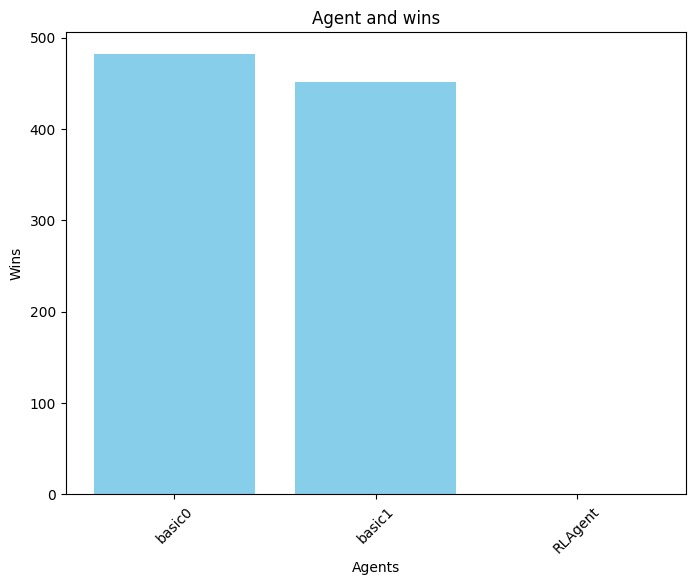

In [ ]:
import matplotlib.pyplot as plt

labels = list(win_counter.keys())
values = list(win_counter.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')

#title
plt.title('Agent and wins')
plt.xlabel('Agents')
plt.ylabel('Wins')

#readability
plt.xticks(rotation=45)

plt.show()

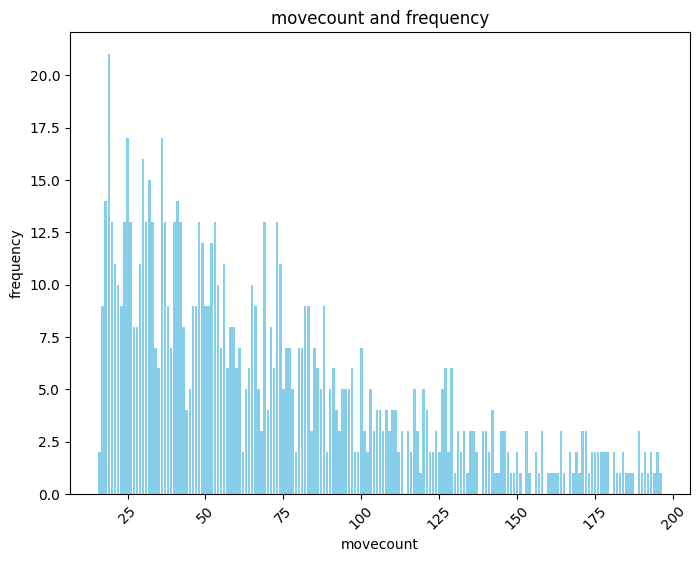

In [ ]:
labels = list(movecount_freq.keys())
values = list(movecount_freq.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')

#title
plt.title('movecount and frequency')
plt.xlabel('movecount')
plt.ylabel('frequency')

#readability
plt.xticks(rotation=45)

plt.show()

In [ ]:
import json

agents = [TestAgent0, TestAgent1, TestRL]

decision_distribution = {}
for i in range(53):
  decision_distribution[index_to_card(i)] = 0

for _ in range(1000):
  TestGame.setup(agents)
  X, Z1, A1, Z2, A2 = TestRL.forward_prop()

  most_likely_selection = decode_decision(A2, deterministic=True)

  decision_distribution[most_likely_selection] += 1

for key, value in decision_distribution.items():
  print(f"{key}: {value}")

(0, 0): 0
(0, 1): 0
(0, 2): 0
(0, 3): 0
(0, 4): 0
(0, 5): 0
(0, 6): 0
(0, 7): 0
(0, 8): 0
(0, 9): 0
(0, 10): 0
(0, 11): 0
(0, 12): 0
(1, 0): 0
(1, 1): 0
(1, 2): 0
(1, 3): 0
(1, 4): 0
(1, 5): 0
(1, 6): 0
(1, 7): 0
(1, 8): 0
(1, 9): 0
(1, 10): 0
(1, 11): 0
(1, 12): 0
(2, 0): 0
(2, 1): 0
(2, 2): 0
(2, 3): 0
(2, 4): 0
(2, 5): 0
(2, 6): 0
(2, 7): 0
(2, 8): 0
(2, 9): 0
(2, 10): 0
(2, 11): 0
(2, 12): 0
(3, 0): 0
(3, 1): 0
(3, 2): 0
(3, 3): 0
(3, 4): 0
(3, 5): 0
(3, 6): 0
(3, 7): 0
(3, 8): 0
(3, 9): 0
(3, 10): 0
(3, 11): 0
(3, 12): 0
(-1, -1): 1000


In [ ]:
TestGame.setup(agents)
X, Z1, A1, Z2, A2 = TestRL.forward_prop()

print(np.column_stack((np.array(list(decision_distribution.keys())), reward_vector(TestGame, TestRL), A2)))

[[ 0.          0.         -0.5         0.01644478]
 [ 0.          1.         -0.5         0.01875988]
 [ 0.          2.         -0.5         0.0191799 ]
 [ 0.          3.         -0.5         0.01930929]
 [ 0.          4.         -0.5         0.01872576]
 [ 0.          5.         -0.5         0.01886825]
 [ 0.          6.         -0.5         0.01897802]
 [ 0.          7.         -0.5         0.01899962]
 [ 0.          8.         -0.5         0.01885947]
 [ 0.          9.         -0.5         0.01855257]
 [ 0.         10.         -0.5         0.01858901]
 [ 0.         11.         -0.5         0.01885157]
 [ 0.         12.         -0.5         0.01909186]
 [ 1.          0.         -0.5         0.01659833]
 [ 1.          1.         -0.5         0.01879542]
 [ 1.          2.         -0.5         0.01855787]
 [ 1.          3.         -0.5         0.01902605]
 [ 1.          4.         -0.5         0.01957997]
 [ 1.          5.         -0.5         0.01907302]
 [ 1.          6.         -0.5 

In [ ]:
# TestRL = RLAgent("RLAgent", TestGame)

# agents = [TestAgent0, TestAgent1, TestRL]


# run_simulation(TestGame, agents, 200, verbose=False)

# np.set_printoptions(suppress=True)#precision=10)

# epsilon = 1e-10
# print((TestRL.get_probabilities() + epsilon).flatten())

# np.set_printoptions(suppress=True, precision=3)

# print(-np.log(TestRL.get_probabilities()).flatten())
# print(move_reward(TestGame, TestRL, TestRL.get_move()))
# print(reward_vector(TestGame, TestRL).flatten())
# #print(advantages(TestGame, TestRL).flatten())

# #this should be the policy gradient, for a single action
# print((-np.log(TestRL.get_probabilities()) * reward_vector(TestGame, TestRL)).flatten())
